# "Поиск отметок источников наружного противопожарного водоснабжения на сканах карты, их идентификация и сопоставление с географическими координатами для последующего формирования базы данных"
---
Дипломный проект

# Введение

Проект написан как дипломная работа по курсу "Data Science, нейронные сети, машинное обучение и искусственный интеллект" от [https://neural-university.ru/](Университета искусственного интеллекта).

Основная идея заключается в разработке программного обеспечения которое позволяло бы находить и сопоставлять с географическими координатами мети источников наружного противопожарного водоснабжения на изображениях (сканах, фотографиях, скриншотах и т.д.).

В настоящее время в пожарных подразделениях Российской Федерации применяются планшеты источников наружного противопожарного водоснабжения. Данные документы как правило представляют из себя брошюру из распечатанных карт районов горда *района выезда пожарного подразделения) с нанесенными на них метками ИНППВ. В настоящее время ведется работа по формированию электронных баз данных ИНППВ в электронном виде с привязкой к географическим координатам. В случае наличия большого количества ИНППВ данная задача может быть весьма трудоемкой, сканирование и распознавание меток с карт позволит упростить эту задачу.

![Пример планшета водоисточника](test_imgs/blanket_example.jpg)


# Описание архитектуры решения

При создании проекта было определено, что для его реализации потребуется решить три задачи решаемые при помощи ИИ (НС):
1. Определение участков изображения на которых присутствует метка ИНППВ
2. Поиск границ метки с целью определения ее центра 
3. Интерпретация метки по типу ИНППВ.

Данным задачам соответствуют следующие задачи ИИ:
1. Классификация (2 класса - есть/нет ИНППВ на изображении)
2. Сегментация (определение границ метки ИНППВ)
3. Классификация (6 классов по количеству типов ИНППВ)

Возможные типы ИНППВ:
* ПГ - Пожарный гидрант
* ПВ - Пожарный водоем
* ПК - Пожарный кран
* Пожарный пирс
* Водонапорная башня
* Колодец

## Работа готового решения
Готовое решение на вход получает изображение произвольного размера и географические координаты рами изображения и возвращает список географических координат и типов меток по этим координатам.

## Внутренне устройство решения
Получаемое изображение карты разбивается на набор фрагментов определенного размера (экспериментально установлен оптимальный размер 32х32 пикселя, но в конечном итоге это зависит от качества изображения и размеров меток). Модель первой фазы отбирает из набора только те изображения, на которых имеются ИНППВ. Модель второй фазы сегментирует изображения ИНППВ, выделяя только области с наличием меток. Изображения сегментаций передаются модели третьей фазы для интерпретации типа ИНППВ. Так же на основе изображений сегментации определяются точки расположения маркеров. На заключительном этапе полученные точки сопоставляются между собой для избежания дублирования. Результаты дополняются географическими координатами вычисленными исходя из координат границ изображения и возвращаются пользователю.

Медли вся внутрення логика объединены в единый класс реализующий весь функционал.

## Обучение моделей.
Обучение моделей производится на наборе предварительно подготовленных и размеченных изображений карт размером 621х621 пикселей (выбран произвольно). Всего 10 простых изображений (без картографической подложки) и 34 реальных карты. На каждом изображении от 10 до 20 ИНППВ разных типов. Каждое из изображений перед обучением разбивается на фрагменты (также размером 32х32 пикселя) с определенным шагом (в ходе экспериментов использовался шаг 8 пикселей).

Модели первой и второй фазы обучаются на полученных наборах. Модель третьей фазы (интерпретация по типу) обучается на сегментированных изображениях полученных от модели второй фазы и соответствующих им метках типов ИНППВ.

## Используемые библиотеки

In [1]:
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD #Подключаем оптимизаторы
from tensorflow.keras.models import Model, load_model #Модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D #Базовые слои
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from tensorflow.keras import backend as K
import tensorflow.config as tfc

# from tensorflow import keras

from matplotlib import pyplot as plt
import numpy as np

import time

from PIL import Image 

import folium

# Задача 1. Работа с изображениями карт

## Основные параметры разбивки изображений

In [33]:
img_size = 32       # Размер фрагмента карты
step = 6            # шаг нарезки карт

imppw_types_dict = {
    0: "ПГ",
    1: "ПВ",
    2: "ПК",
    3: "Пирс",
    4: "Башня",
    5: "Колодец"
}

## Функции работы с изображениями карт

In [28]:
class dbc(object):
    @staticmethod
    def is_INPPW_inPoint(mask, coords, approval=5):
        maxColor = np.max(mask[coords[0],coords[1],:])                           
        if maxColor > approval:
            return True
        else:
            return False

    @staticmethod
    def is_boundsCollision(mask, coords, approval=5):
        maxUp = np.max(mask [ coords[0]:coords[2], coords[3] ] )
        maxLow = np.max(mask [ coords[0]:coords[2], coords[1] ] )
        maxLeft = np.max(mask [ coords[0], coords[1]:coords[3] ] )
        maxRight = np.max(mask [ coords[2], coords[1]:coords[3] ] )

        if maxUp>approval or maxLow>approval or maxLeft>approval or maxRight>approval:
            return True
        else:
            return False

    @staticmethod
    def get_INPPWType(mask_slice, approval=5):
        '''
            Case Is = "ПГ"=0
                color = "255,0,0"
            Case Is = "ПВ"=1
                color = "0,255,0"
            Case Is = "ПК"=2
                color = "0,0,255"
            Case Is = "Пирс"=3
                color = "255,255,0"
            Case Is = "Башня"=4
                color = "255,0,255"
            Case Is = "Колодец"=5
                color = "0,255,255"
        '''
        m = 255-approval    #Минимально приемлемое значение канала, для того чтобы он считался активированным
        r = np.max(mask_slice[:,:,0] )   > m
        g = np.max(mask_slice[:,:,1] )   > m
        b = np.max(mask_slice[:,:,2] )   > m
        

        if r  and  not g  and  not b:   #"ПГ"
            return 0
        if not r  and  g  and  not b:   #"ПВ"
            return 1
        if not r  and  not g  and  b:   #"ПК"
            return 2
        if r  and  g  and  not b:   #"Пирс"
            return 3
        if r  and  not g  and  b:   #"Башня"
            return 4
        if not r  and  g  and  b:   #"Колодец"
            return 5
        
        # Если ничего, то возвращаем отрицательное значение
        return -1


    @staticmethod
    def correctImgs(source):
        '''
            Функция возвращает откорректированный список
        '''
        x_train_l = []
        for i in range(source.shape[0]):
            x_train_l.append(list(source[i]))
        x_train_np = np.array(x_train_l)

        return x_train_np


    @staticmethod
    def get_ImageSlice(original, size, step, addCoords=False):
        '''
            Функция возвращает нарезку изображений из исходного
                Вход:
                    original - исходное изображение
                    size - размер итоговых изображений (высота=ширина)
                    step - шаг поиска ИНППВ
                Выход:
                    imgSet - numpy массив изображений с указанными параметрами
                    crdSet - набор координат ([нижний левый угол, верхний правый) для каждого изображения
        '''
        # Определяем размеры изображения
        orig_np = np.array(original)  
        orig_img_shape = orig_np.shape

        maxX = orig_img_shape[1]
        maxY = orig_img_shape[0]

        # Формируем перечень картинок
        imgSet = []         # Список изображений карт
        crdSet = []         # Список координат изображений
        # В цикле с шагом step пробегаем по всему изображению 
        for x in range(0, maxX-size, step):    
            for y in range(0, maxY-size, step):
                imgSet.append(
                        list(orig_np[y:y + size, x:x + size, :])
                    )
                if addCoords:
                    crdSet.append([x, y, x + size, y + size])

        if addCoords:
            return np.array(imgSet), crdSet
        else:
            return np.array(imgSet)


    @staticmethod
    def get_ImageSlice_Single(original, coords):
        '''
            Функция возвращает вырезанное изображение из исходного
                Вход:
                    original - исходное изображение
                    coords - координаты вырезки
                Выход:
                    img - вырезанное изображение 

        '''
        # Определяем размеры изображения
        orig_np = np.array(original)  
        return orig_np[coords[1]:coords[3], coords[0]:coords[2], :]


    @staticmethod
    def get_StudySets(img_names, rng, step, studySetOnly=True):
        mainTime = time.time()

        img_full = []           # Исходные изображения
        img_inppw_mrkr = []     # Маркер наличия ИНППВ на изображении

        for img_name in img_names:
            curTime = time.time()

            img_gisp = Image.open(img_name.format('gisp'))
            img_mask = Image.open(img_name.format('mask'))

            imgSet = dbc.get_ImageSlice(img_gisp, rng, step)
            mskSet = dbc.get_ImageSlice(img_mask, rng, step)

            positive_count = 0
            for i in range(len(mskSet)):
                # Добавляем исходное изображение в общий набор изображений
                img = imgSet[i]

                # Получаем маску нарезки исходного изображения и далее работаем с ней
                msk = mskSet[i]
                # Середина нарезки
                x = int(msk.shape[0]/2)

                # Проверяем имеется ли на нарезке ИНППВ
                inppw = dbc.is_INPPW_inPoint(msk, [x, x])
                if inppw:       
                    # если имеется, и при этом оно не касается границ (ближе к центру нарезки)  #!!! Следует изучить особенности обучения НС на наборах в которых метка ИНППВ касается контура изображения и на тех, где не каается
                    # if not dbc.is_boundsCollision(msk, [0,0,msk.shape[0]-1,msk.shape[0]-1]):
                    # добавлем класс ИНППВ
                    img_inppw_mrkr.append(dbc.get_INPPWType(msk))
                    img_full.append(img)
                    positive_count+=1
                else:
                    img_inppw_mrkr.append(-1)
                    img_full.append(img)

            # Подводим итог по картинке idx
            positive_count_all = sum([1 if x>=0 else 0 for x in img_inppw_mrkr])

            print(img_name,
                str(round(time.time()-curTime,2))+"c., "
                "Получено " + str(positive_count) + " изображений c ИНППВ. " +
                "Всего: " + str(positive_count_all))


        # Если нужен только учебный набор, то производим его наполнение:
        if studySetOnly:
            newImg_set = []
            newMrk_set = []
            positive_count = 0

            # Формируем новый набор изображений с наличием ИНППВ, удаляя их из полного набора
            for i in range(len(img_inppw_mrkr)):
                if img_inppw_mrkr[i]>=0:
                    newImg_set.append(img_full[i])
                    newMrk_set.append(img_inppw_mrkr[i])
                    positive_count+=1

            # Из оставшихся в полном наборе записей формируем список изображений 
            # той же длины, что и список изображений с ИНППВ
            # Note: здесь используется полный набор индексов, так что в итоговый список 
            # могут попадать  в том числе и картинки с ИНППВ уже внесенные в список ранее
            # позже нужно будет это исправить
            idxs = np.random.choice(len(img_full), positive_count, replace=False)
            for idx in idxs:
                newImg_set.append(img_full[idx])
                newMrk_set.append(img_inppw_mrkr[idx])

            img_full = newImg_set
            img_inppw_mrkr = newMrk_set

        # Превращаем в numpy массив
        img_full = np.array(img_full)
        img_inppw_mrkr = np.array(img_inppw_mrkr)

        print("Времени потребовалось: ", 
            str(round(time.time()-mainTime,2))+"c., ",
            "Всего карт: " + str(img_inppw_mrkr.shape[0]))

        return img_full, img_inppw_mrkr


    @staticmethod
    def get_StudySets_ForInterpretation(img_names, rng, step, studySetOnly=True):
        mainTime = time.time()

        img_full = []           # Исходные изображения
        img_inppw_mrkr = []     # Маркер наличия ИНППВ на изображении
        # img_inppw_type = []     # класс ИНППВ изображенного на картинке

        for img_name in img_names:
            curTime = time.time()

            img_mask = Image.open(img_name.format('mask'))

            mskSet = dbc.get_ImageSlice(img_mask, rng, step)

            positive_count = 0
            for i in range(len(mskSet)):
                # Добавляем исходное изображение в общий набор изображений

                # Получаем маску нарезки исходного изображения и далее работаем с ней
                msk = mskSet[i]
                # Середина нарезки
                x = int(msk.shape[0]/2)

                # Проверяем имеется ли на нарезке ИНППВ
                inppw = dbc.is_INPPW_inPoint(msk, [x, x])
                if inppw:       
                    # если имеется, и при этом оно не касается границ (ближе к центру нарезки)
                    if not dbc.is_boundsCollision(msk, [0,0,msk.shape[0]-1,msk.shape[0]-1]):
                        # добавлем класс ИНППВ
                        img_inppw_mrkr.append(dbc.get_INPPWType(msk))
                        img_full.append(msk)
                        positive_count+=1

            # Подводим итог по картинке idx
            positive_count_all = sum([1 if x>=0 else 0 for x in img_inppw_mrkr])

            print(img_name,
                str(round(time.time()-curTime,2))+"c., "
                "Получено " + str(positive_count) + " изображений c ИНППВ. " +
                "Всего: " + str(positive_count_all))


        # Превращаем в numpy массив
        img_full = np.array(img_full)
        img_inppw_mrkr = np.array(img_inppw_mrkr)

        print("Времени потребовалось: ", 
            str(round(time.time()-mainTime,2))+"c., ",
            "Всего карт: " + str(img_inppw_mrkr.shape[0]))

        return img_full, img_inppw_mrkr


    @staticmethod
    def get_StudySetsForSegmentation(img_names, rng, step, RGB=False):
        '''
            Функция для получения набора фрагментов карты с нанесенными ИНППВ
            и набора фрагментов карты с их размеченными контурами
        '''
        
        mainTime = time.time()

        img_full = []           # Исходные изображения
        msk_full = []           # Маски разметки с индексами 0-1 (о нет ИНППВ, 1 - есть)

        for img_name in img_names:
            curTime = time.time()

            img_gisp = Image.open(img_name.format('gisp'))
            img_mask = Image.open(img_name.format('mask'))

            imgSet = dbc.get_ImageSlice(img_gisp, rng, step)
            mskSet = dbc.get_ImageSlice(img_mask, rng, step)

            positive_count = 0
            for i in range(len(mskSet)):
                # Получаем исходное изображение
                img = imgSet[i]
                # Получаем маску нарезки исходного изображения и далее работаем с ней
                msk = mskSet[i]
                # Середина нарезки
                x = int(msk.shape[0]/2)

                # Проверяем имеется ли на нарезке ИНППВ
                inppw = dbc.is_INPPW_inPoint(msk, [x, x])
                if inppw:       
                    # если имеется, и при этом оно не касается границ (ближе к центру нарезки)
                    if not dbc.is_boundsCollision(msk, [0,0,msk.shape[0]-1,msk.shape[0]-1]):
                        # добавлем класс ИНППВ
                        img_full.append(img)
                        if RGB:
                            msk_full.append(msk)
                        else:
                            msk_full.append(np.maximum.reduce(msk, 2))
                        positive_count+=1

            # Подводим итог по картинке idx
            positive_count_all = len(img_full)

            print(img_name,
                str(round(time.time()-curTime,2))+"c., "
                "Получено " + str(positive_count) + " изображений c ИНППВ. " +
                "Всего: " + str(positive_count_all))

        # Превращаем в numpy массив
        img_full = np.array(img_full)
        msk_full = np.array(msk_full)

        print("Времени потребовалось: ", 
            str(round(time.time()-mainTime,2))+"c., ",
            "Всего карт: " + str(img_full.shape[0]))

        return img_full, msk_full


    @staticmethod
    def pntFilter(pnt, border=210):
        if pnt>=border:
            return pnt
        else:
            return 0

## Списки наименований изображений карт для обучения моделей

In [4]:
# =============== Перечни изображений ==================
# наборы простых изображений
short_soft_gisp = ['imgs_soft/' + str(i) + '_{}_FN.jpg' for i in range(1, 5)]
full_soft_gisp = ['imgs_soft/' + str(i) + '_{}_FN.jpg' for i in range(1, 11)]

# наборы обычных изображений
short_middle_gisp = ['imgs/' + str(i) + '_{}_FN.jpg' for i in range(1, 10)]
full_middle_gisp = ['imgs/' + str(i) + '_{}_FN.jpg' for i in range(1, 34)]

# наборы сложных изображений



# наборы новых для НС изображений


# Полные наборы изображений
total_gisp = full_middle_gisp + full_soft_gisp

# Функции работы с моделями

In [5]:
class mdl_wrk(object):
    @staticmethod
    def get_StudySet_forFase1(img_names, rng, step, studySetOnly=True, trainVal = 0.8):
        imgs, mrks = dbc.get_StudySets(img_names, rng, step, studySetOnly)
        size = mrks.shape[0]

        # Morph imgs set to 0:1 float diapasone
        imgs = imgs/255
        
        # Correct markers existance set
        inppw_ex = []
        for i in range(size):
            if mrks[i] >= 0:
                inppw_ex.append( [0.,1.] )
            else:
                inppw_ex.append( [1.,0.] )
        inppw_ex = np.array(inppw_ex)

        # Разбиваем на выборки
        x_train, x_test, y_train, y_test = train_test_split(
                                        imgs, inppw_ex, 
                                        train_size=trainVal, shuffle=True
                                        )
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

        return [x_train, y_train, x_test, y_test]


    @staticmethod
    def get_StudySet_forFase2(img_names, rng, step, numclasses=2, trainVal = 0.8):
        imgs, msks = dbc.get_StudySetsForSegmentation(img_names, rng, step)

        # Morph imgs set to 0:1 float diapasone
        imgs = imgs/255
        msks = msks/255

        msks =np.reshape(msks, (msks.shape[0],rng,rng,1))
        
        # Разбиваем на выборки
        x_train, x_test, y_train, y_test = train_test_split(
                                        imgs, msks, 
                                        train_size=trainVal, shuffle=True
                                        )

        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

        return [x_train, y_train, x_test, y_test]


    @staticmethod
    def get_BaseStudySet_forFase3(img_names, rng, step, numclasses=2, trainVal = 0.8):
        imgs, msks = dbc.get_StudySetsForSegmentation(img_names, rng, step, RGB=True)

        # Morph imgs set to 0:1 float diapasone
        imgs = imgs/255
        msks = msks/255
        
        # Разбиваем на выборки
        x_train, x_test, y_train, y_test = train_test_split(
                                        imgs, msks, 
                                        train_size=trainVal, shuffle=True
                                        )

        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

        return [x_train, y_train, x_test, y_test]


    @staticmethod
    def mdlTrain(mdl, data, epochs, batch_size):
        history = mdl.fit(
            data[0], data[1],
            epochs=epochs, batch_size=batch_size,
            validation_data=(data[2], data[3])
        )

        return history


    @staticmethod
    def showImgs(imgs, mrks, ncols=5):
        nrows = int(len(imgs)/ncols) 
        fig, axs = plt.subplots(nrows, ncols, figsize=(10, 2*nrows))
        for i in range(nrows):
            for j in range(ncols):
                img = imgs[i*5+j]
                axs[i,j].imshow( img.astype(np.int32) )
                axs[i,j].set_title(str(mrks[i*ncols+j]))
                axs[i,j].set_axis_off()

        plt.show()


def checkModel_Fase1(mdl, imgs, mrks, size, ncols=5):
    '''
        Проверка качества обученности модели для фазы 1
            Вход:
                mdl - модель
                imgs - набор фрагментов карты для оценки расположения на них ИНППВ
                mrks - проверочные сведения о нахождении на картинках карты
                size - размер картинок карты
                ncols - количество строк на графике
    '''
    nrows = int(len(imgs)/ncols) 
    fig, axs = plt.subplots(nrows, ncols, figsize=(10, 2*nrows))
    for i in range(nrows):
        for j in range(ncols):
            img = imgs[i*5+j]
            
            pred = np.argmax(mdl.predict(img.reshape([-1, size, size , 3])))            
            
            axs[i,j].imshow( img.astype(np.int32) )
            mrk = np.argmax(mrks[i*ncols+j])
            axs[i,j].set_title(str(pred) +" (" + str(mrk) + ")")
            axs[i,j].set_axis_off()
    
    plt.show()



# Задача 2. Определение наличия ИНППВ на фрагменте карты

## Архитектура модели

In [6]:
def getModel_F1_2(shape=(30,30,3), out_shape=2):
    '''
        Simple sequential convolutional dense net (SSCDN):
            In:
                shape - shape of incoming images
            Out: 
                np.array with out_shape size - [y1, y2]. [1, 0] - ИНППВ на фрагменте имеется, [0, 1] - ИНППВ на фрагменте имеется
    '''
    inp = Input((shape), name="image_input")

    x = Conv2D(64, (3,3), activation='relu') (inp)
    x = Dropout(0.2) (x)
    x = BatchNormalization() (x)
    x = MaxPooling2D() (x)

    x = Conv2D(64, (3,3), activation='relu') (x)
    x = Dropout(0.2) (x)
    x = BatchNormalization() (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    x = Dense(568, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    x = Dense(256, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    x = Dense(64, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    x = Dense(32, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    end = Dense(out_shape, activation='sigmoid') (x)


    return Model(inp, end)

## Обучение модели

In [7]:
# Формируем данные для обучения модели 1
data = mdl_wrk.get_StudySet_forFase1(total_gisp, img_size, step)

# Создание экземпляра модели
mdl1 = getModel_F1_2(shape = (img_size,img_size,3) )
mdl1.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy')

imgs/1_{}_FN.jpg 0.94c., Получено 224 изображений c ИНППВ. Всего: 224
imgs/2_{}_FN.jpg 1.0c., Получено 299 изображений c ИНППВ. Всего: 520
imgs/3_{}_FN.jpg 0.89c., Получено 110 изображений c ИНППВ. Всего: 630
imgs/4_{}_FN.jpg 0.94c., Получено 285 изображений c ИНППВ. Всего: 915
imgs/5_{}_FN.jpg 1.19c., Получено 92 изображений c ИНППВ. Всего: 1007
imgs/6_{}_FN.jpg 1.33c., Получено 169 изображений c ИНППВ. Всего: 1176
imgs/7_{}_FN.jpg 1.35c., Получено 145 изображений c ИНППВ. Всего: 1321
imgs/8_{}_FN.jpg 0.88c., Получено 256 изображений c ИНППВ. Всего: 1577
imgs/9_{}_FN.jpg 1.04c., Получено 150 изображений c ИНППВ. Всего: 1727
imgs/10_{}_FN.jpg 0.95c., Получено 174 изображений c ИНППВ. Всего: 1901
imgs/11_{}_FN.jpg 0.89c., Получено 215 изображений c ИНППВ. Всего: 2116
imgs/12_{}_FN.jpg 0.89c., Получено 306 изображений c ИНППВ. Всего: 2416
imgs/13_{}_FN.jpg 1.02c., Получено 284 изображений c ИНППВ. Всего: 2700
imgs/14_{}_FN.jpg 0.91c., Получено 224 изображений c ИНППВ. Всего: 2924
imgs/15

In [8]:
mdl1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)       

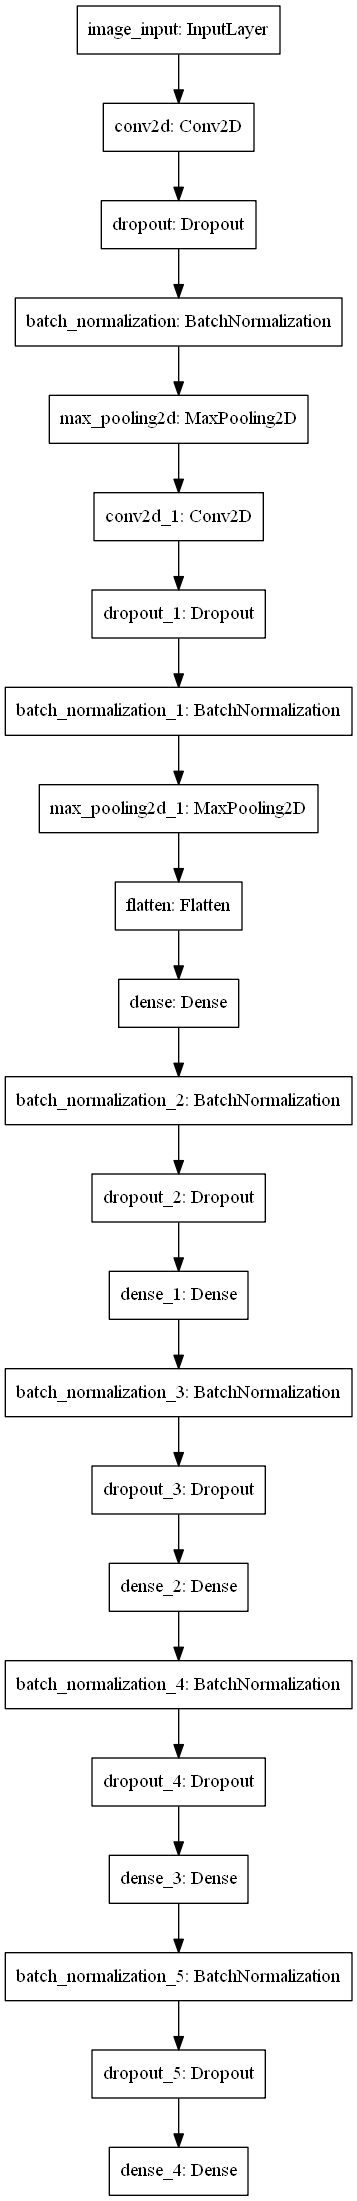

In [9]:
plot_model(mdl1)

In [10]:
# Тренировка модели
mdl_wrk.mdlTrain(mdl1, data, epochs=30, batch_size=10)

Epoch 1/30
 899/1936 [============>.................] - ETA: 1:15 - loss: 0.1756

## Проверка обучения

[ 26 608 509 633 325 535 301 221 423 604 802 747 313 722 278 557 593 576
 267 529]


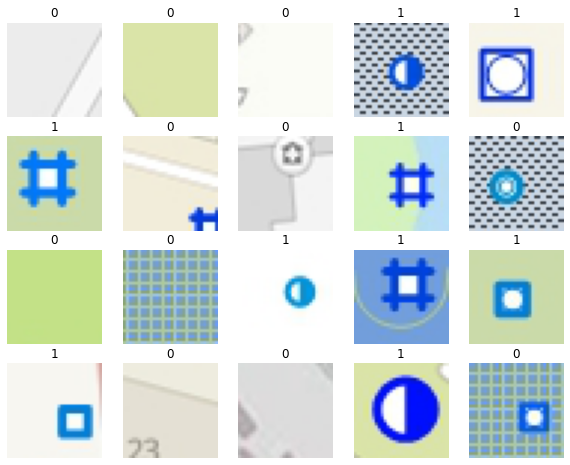

In [ ]:
# На учебном наборе - не случилось ли переобучения
imgs = data[2]
mrks = data[3]

idx_rnd = np.random.randint(0, len(mrks), 20)
print(idx_rnd)

imgsList = imgs[idx_rnd]
mrksList = mrks[idx_rnd]

# Получаем предсказание и визуализируем его
pred = mdl1.predict(imgsList)
pred = [np.argmax(x) for x in pred]
mdl_wrk.showImgs(imgsList*255, pred)

(10000, 2)
160
21


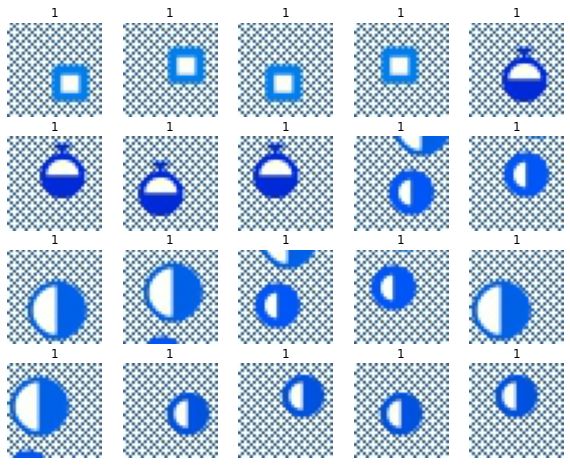

In [ ]:
#%% На новом изображении карты
test_map = Image.open("imgs_soft/9_gisp_FN.jpg")
imgs_test = dbc.get_ImageSlice(test_map, img_size, step)

pred = mdl1.predict(imgs_test/255)
print(pred.shape)

cnt2=0
for i in range(len(pred)):
    if np.argmax(pred[i])==1:
        cnt2+=1
print(str(cnt2))

img_positive = []
mrks_positive = []
cnt = 0
for i in range(len(pred)):
    if np.argmax(pred[i])==1:
        img_positive.append(imgs_test[i])
        mrks_positive.append(1)
        if cnt>20: break
        cnt+=1
print(cnt) 
if cnt>0:
    mdl_wrk.showImgs(img_positive, mrks_positive)
else:
    print("No one responded images!")

(10000, 2)
146
21


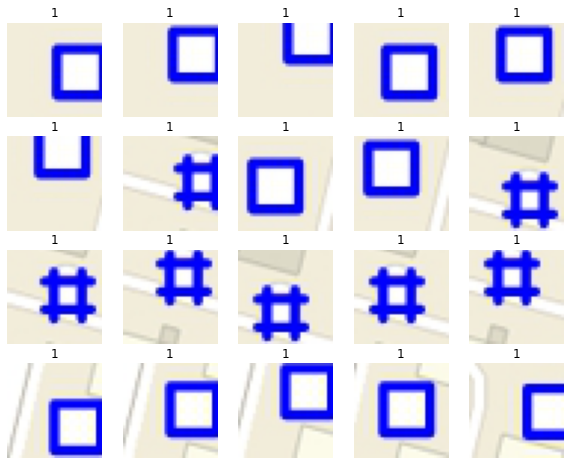

In [ ]:
test_map = Image.open("test_imgs/1_gisp_PN.jpg")
imgs_test = dbc.get_ImageSlice(test_map, img_size, 6)

pred = mdl1.predict(imgs_test/255)
print(pred.shape)

cnt2=0
for i in range(len(pred)):
    if np.argmax(pred[i])==1:
        cnt2+=1
print(str(cnt2))

img_positive = []
mrks_positive = []
cnt = 0
for i in range(len(pred)):
    if np.argmax(pred[i])==1:
        img_positive.append(imgs_test[i])
        mrks_positive.append(1)
        if cnt>20: break
        cnt+=1
print(cnt) 
if cnt>0:
    mdl_wrk.showImgs(img_positive, mrks_positive)
else:
    print("No one responded images!")

## Сохранение/Загрузка

In [ ]:
# mdl1.save("models/F1_Full_0")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/F1_Full_0\assets


# Задача 3. Сегментация изображения карты

## Архитектура модели

In [ ]:
def getModel_Segm_4(shape=(32,32,3)):
    '''
        Модель с ветвлением:
            In:
            shape - shape of incoming images
    '''
    inp = Input((shape), name="image_input")

    convsmall = Conv2D(64, (1,1), padding='same') (inp)
    bnSmall = BatchNormalization() (convsmall)
    doSmall = Dropout(0.2) (bnSmall)

    convMiddle = Conv2D(64, (3,3), padding='same') (inp)
    bnMiddle = BatchNormalization() (convMiddle)
    doMiddle = Dropout(0.2) (bnMiddle)

    convLarge= Conv2D(64, (5,5), padding='same') (inp)
    bnLarge = BatchNormalization() (convLarge)
    doLarge = Dropout(0.2) (bnLarge)

    convXLarge= Conv2D(64, (7,7), padding='same') (inp)
    bnXLarge = BatchNormalization() (convXLarge)
    doXLarge = Dropout(0.2) (bnXLarge)


    cocn1 = concatenate([doSmall, doMiddle, doLarge, doXLarge])
    convSumm = Conv2D(64, (3,3), padding='same') (cocn1)



    

    end = Conv2D(1, (3, 3), padding='same',
                activation='sigmoid', 
                name="end") (convSumm)

    return Model(inp, end)

## Обучение модели

In [ ]:
# Загрузка данных
data2 = mdl_wrk.get_StudySet_forFase2(total_gisp, img_size, step)

# Создание экземпляра модели
mdl2 = getModel_Segm_4(shape = (img_size,img_size,3))
mdl2.compile(optimizer=SGD(learning_rate=0.0001),
                  loss='mean_squared_error')  

imgs/1_{}_FN.jpg 1.37c., Получено 53 изображений c ИНППВ. Всего: 53
imgs/2_{}_FN.jpg 0.95c., Получено 49 изображений c ИНППВ. Всего: 102
imgs/3_{}_FN.jpg 0.91c., Получено 26 изображений c ИНППВ. Всего: 128
imgs/4_{}_FN.jpg 0.96c., Получено 47 изображений c ИНППВ. Всего: 175
imgs/5_{}_FN.jpg 0.92c., Получено 15 изображений c ИНППВ. Всего: 190
imgs/6_{}_FN.jpg 0.95c., Получено 28 изображений c ИНППВ. Всего: 218
imgs/7_{}_FN.jpg 0.99c., Получено 50 изображений c ИНППВ. Всего: 268
imgs/8_{}_FN.jpg 0.93c., Получено 45 изображений c ИНППВ. Всего: 313
imgs/9_{}_FN.jpg 0.91c., Получено 34 изображений c ИНППВ. Всего: 347
imgs/10_{}_FN.jpg 0.91c., Получено 35 изображений c ИНППВ. Всего: 382
imgs/11_{}_FN.jpg 0.94c., Получено 36 изображений c ИНППВ. Всего: 418
imgs/12_{}_FN.jpg 0.92c., Получено 41 изображений c ИНППВ. Всего: 459
imgs/13_{}_FN.jpg 1.21c., Получено 41 изображений c ИНППВ. Всего: 500
imgs/14_{}_FN.jpg 0.93c., Получено 35 изображений c ИНППВ. Всего: 535
imgs/15_{}_FN.jpg 1.03c., Полу

In [ ]:
mdl2.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 64)   256         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   1792        image_input[0][0]                
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 64)   4864        image_input[0][0]                
_______________________________________________________________________________________

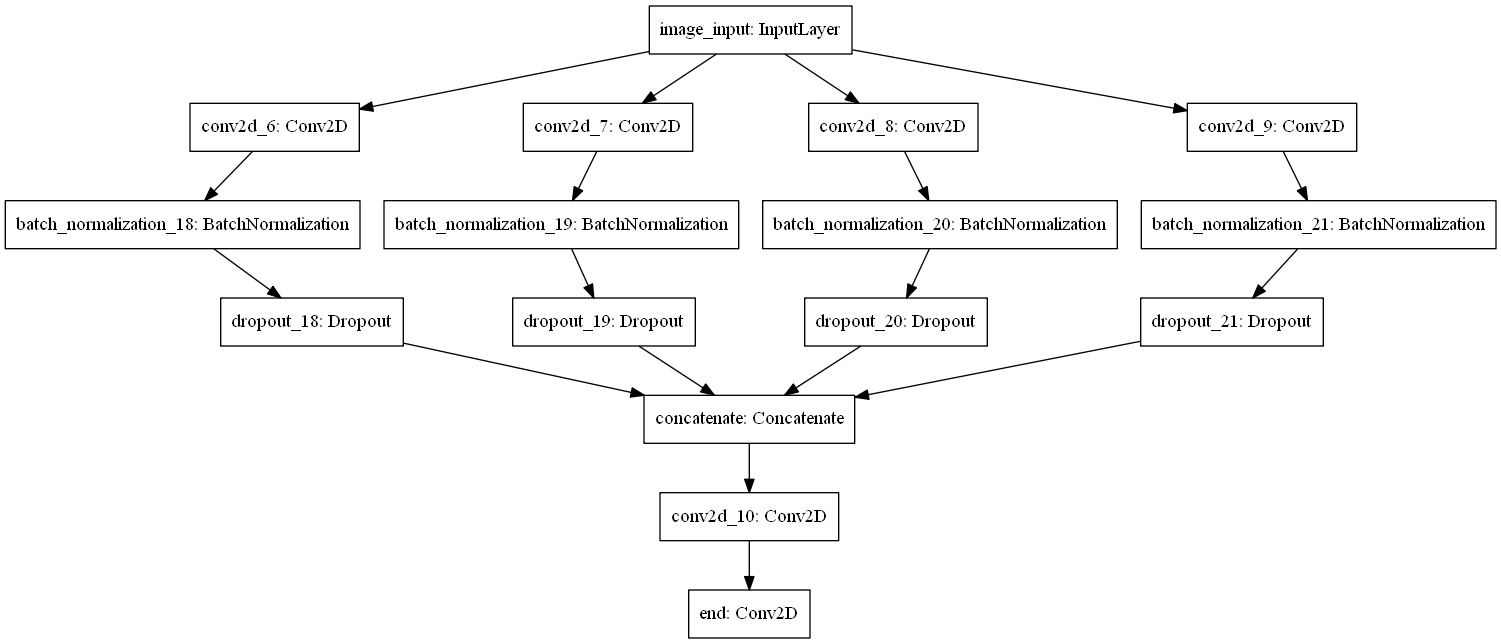

In [ ]:
plot_model(mdl2)

In [ ]:
mdl_wrk.mdlTrain(mdl2, data2, epochs=10, batch_size=25)

Epoch 1/10
68/68 [==============================] - 160s 2s/step - loss: 0.3944 - val_loss: 0.2670
Epoch 2/10
68/68 [==============================] - 154s 2s/step - loss: 0.2921 - val_loss: 0.2174
Epoch 3/10
68/68 [==============================] - 157s 2s/step - loss: 0.2407 - val_loss: 0.1963
Epoch 4/10
68/68 [==============================] - 156s 2s/step - loss: 0.2162 - val_loss: 0.1835
Epoch 5/10
68/68 [==============================] - 156s 2s/step - loss: 0.2015 - val_loss: 0.1752
Epoch 6/10
68/68 [==============================] - 146s 2s/step - loss: 0.1914 - val_loss: 0.1684
Epoch 7/10
68/68 [==============================] - 152s 2s/step - loss: 0.1832 - val_loss: 0.1628
Epoch 8/10
68/68 [==============================] - 159s 2s/step - loss: 0.1767 - val_loss: 0.1597
Epoch 9/10
68/68 [==============================] - 148s 2s/step - loss: 0.1709 - val_loss: 0.1540
Epoch 10/10
68/68 [==============================] - 158s 2s/step - loss: 0.1663 - val_loss: 0.1479


## Проверка обучения

[237 166 170 142  70 132 371  11 328 268]


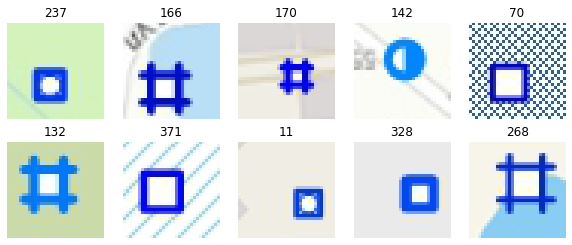

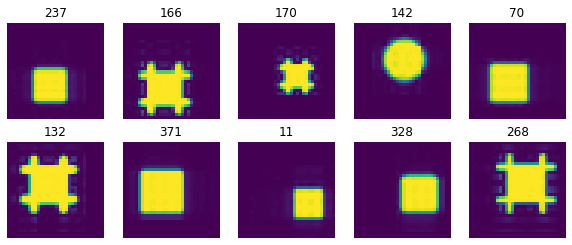

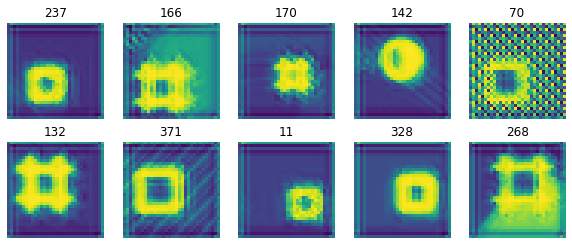

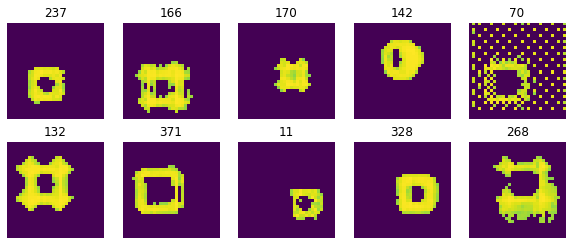

In [ ]:
# На учебном наборе - не случилось ли переобучения
imgs = data2[2]
msks = data2[3]*255

idx_rnd = np.random.randint(0, len(msks), 10)
print(idx_rnd)

imgsList = imgs[idx_rnd]
msksList = msks[idx_rnd]


pred = mdl2.predict(imgsList)
pred= pred*255


# #%%
pred_f = np.vectorize(dbc.pntFilter, otypes=[float])(pred)
mdl_wrk.showImgs(imgsList*255, idx_rnd)
mdl_wrk.showImgs(msksList, idx_rnd)
mdl_wrk.showImgs(pred, idx_rnd)
mdl_wrk.showImgs(pred_f, idx_rnd)

[ 99 409 132  52 217 167 180 227 124 262 180 320 371  95 198 359 252 405
 283 150]


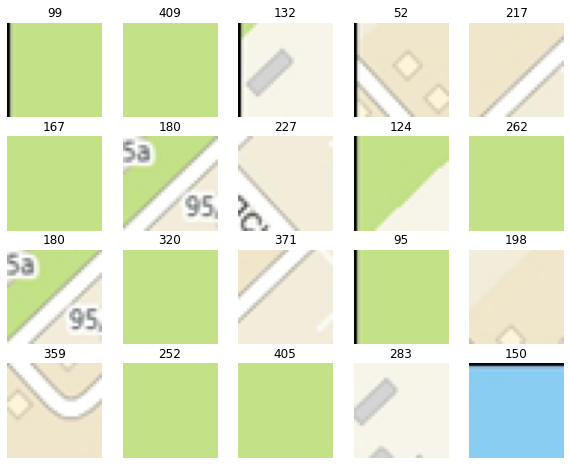

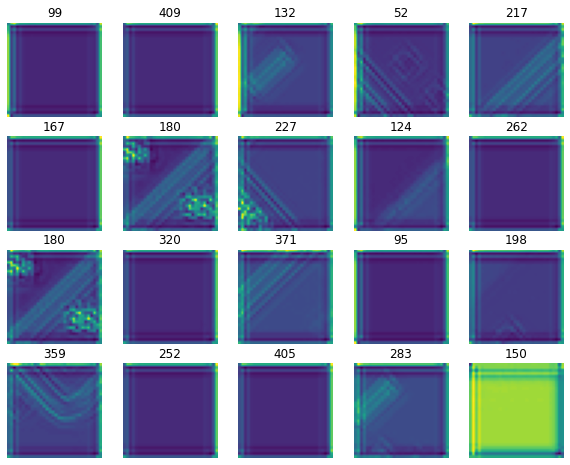

In [ ]:
# На новом изображении карты
test_map = Image.open("test_imgs/7_gisp_PN.jpg")
imgs = dbc.get_ImageSlice(test_map, img_size, 4) / 255

idx_rnd = np.random.randint(0, len(msks), 20)
print(idx_rnd)

imgsList = imgs[idx_rnd]

pred = mdl2.predict(imgsList)
pred= pred*255

mdl_wrk.showImgs(imgsList*255, idx_rnd)
mdl_wrk.showImgs(pred, idx_rnd)

## Сохранение/Загрузка

In [ ]:
# mdl2.save('models/F3_Full_30_1')

# Задача 4. Идентификация ИНППВ

## Архитектура модели

In [ ]:
def getModel_F3_1(shape=(30,30,3), out_shape=2):
    '''
        Simple sequential dense net (SSCDN):
            In:
            shape - shape of incoming images
    '''
    inp = Input((shape), name="image_input")

    x = Conv2D(64, (3,3), padding='same', activation='relu') (inp)
    x = Dropout(0.2) (x)
    x = BatchNormalization() (x)
    x = MaxPooling2D() (x)

    x = Conv2D(64, (3,3), padding='same', activation='relu') (x)
    x = Dropout(0.2) (x)
    x = BatchNormalization() (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)
    x = Dense(568, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    x = Dense(256, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    x = Dense(64, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    x = Dense(32, activation='relu') (x)
    x = BatchNormalization() (x)
    x = Dropout(0.2) (x)

    end = Dense(out_shape, activation='sigmoid') (x)


    return Model(inp, end)

## Обучение модели

In [ ]:
# Создаем экземпляр модели
mdl3 = getModel_F3_1(shape = (img_size,img_size,1), out_shape=6 )

mdl3.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy')   

In [ ]:
mdl3.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
dropout_23 (Dropout)         (None, 16, 16, 64)       

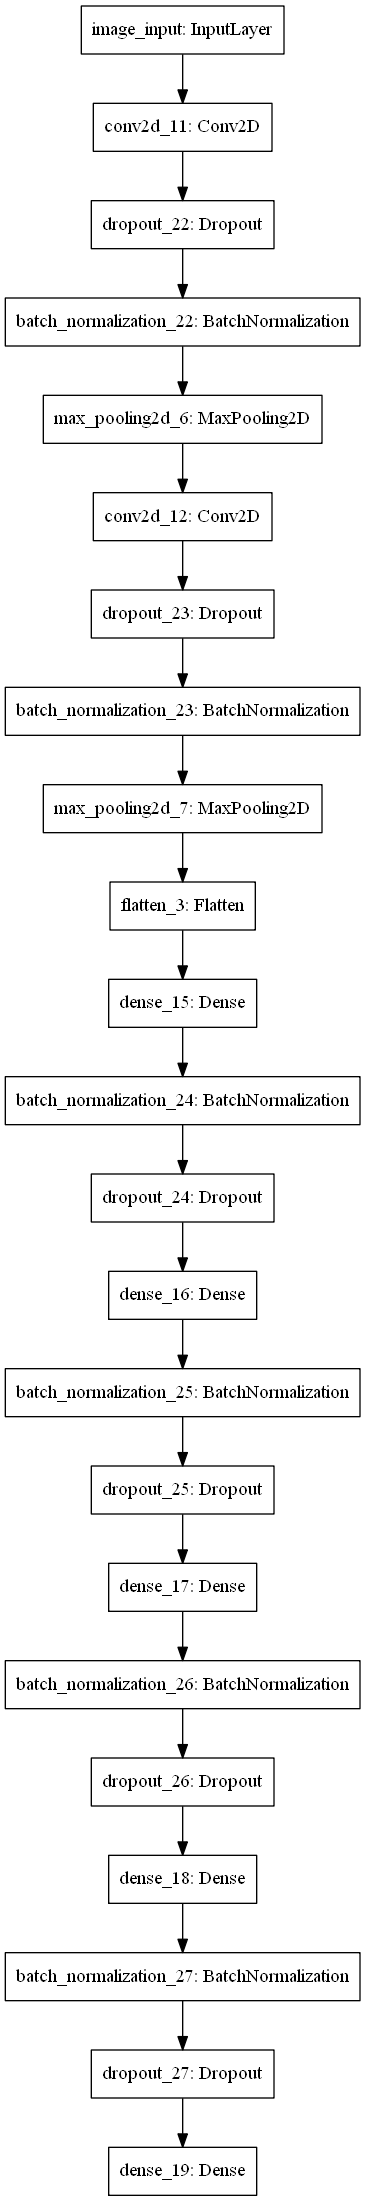

In [ ]:
plot_model(mdl3)

In [ ]:
#%% Получаем набор изображений
data_base = mdl_wrk.get_BaseStudySet_forFase3(total_gisp, img_size, step, trainVal=0.99)

imgs/1_{}_FN.jpg 1.49c., Получено 53 изображений c ИНППВ. Всего: 53
imgs/2_{}_FN.jpg 1.0c., Получено 49 изображений c ИНППВ. Всего: 102
imgs/3_{}_FN.jpg 0.95c., Получено 26 изображений c ИНППВ. Всего: 128
imgs/4_{}_FN.jpg 1.14c., Получено 47 изображений c ИНППВ. Всего: 175
imgs/5_{}_FN.jpg 1.16c., Получено 15 изображений c ИНППВ. Всего: 190
imgs/6_{}_FN.jpg 0.94c., Получено 28 изображений c ИНППВ. Всего: 218
imgs/7_{}_FN.jpg 1.12c., Получено 50 изображений c ИНППВ. Всего: 268
imgs/8_{}_FN.jpg 1.11c., Получено 45 изображений c ИНППВ. Всего: 313
imgs/9_{}_FN.jpg 1.14c., Получено 34 изображений c ИНППВ. Всего: 347
imgs/10_{}_FN.jpg 1.21c., Получено 35 изображений c ИНППВ. Всего: 382
imgs/11_{}_FN.jpg 1.28c., Получено 36 изображений c ИНППВ. Всего: 418
imgs/12_{}_FN.jpg 1.12c., Получено 41 изображений c ИНППВ. Всего: 459
imgs/13_{}_FN.jpg 1.05c., Получено 41 изображений c ИНППВ. Всего: 500
imgs/14_{}_FN.jpg 1.2c., Получено 35 изображений c ИНППВ. Всего: 535
imgs/15_{}_FN.jpg 1.02c., Получе

In [ ]:
# Отдаем модели сегментации (!) набор изображений и получаем предсказанные картинки
pred_base = mdl2.predict(data_base[0])
pred_base = pred_base*255

# Обрабатываем предсказание, с тем, чтобы отфильтровать лишние пиксели
pred_base_f = np.vectorize(dbc.pntFilter, otypes=[float])(pred_base)

[ 244 1530 1562 1779 1130  623  407  653   33   23]


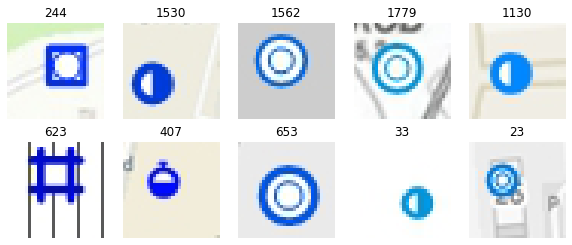

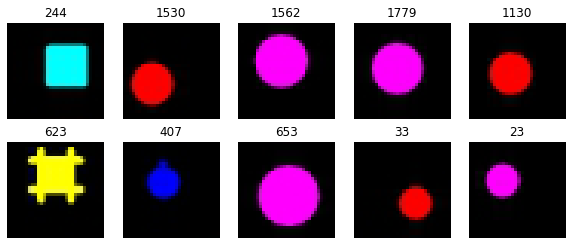

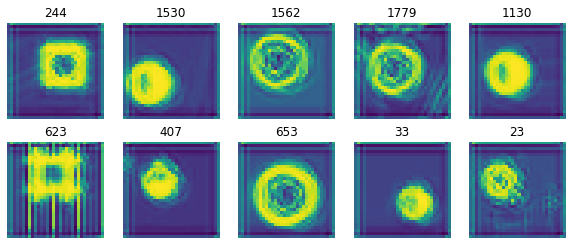

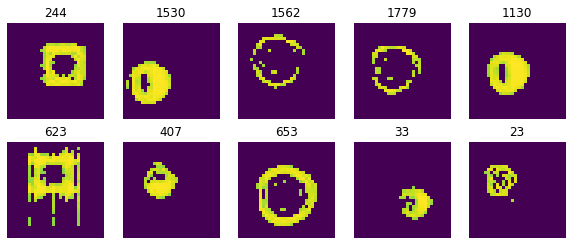

In [ ]:
## Показываем что получилось
idx_rnd = np.random.randint(0, len(pred_base_f), 10)
print(idx_rnd)

imgsList = data_base[0][idx_rnd]
msksList = data_base[1][idx_rnd]
pred_base_List = pred_base[idx_rnd]
pred_base_f_List = pred_base_f[idx_rnd]

mdl_wrk.showImgs(imgsList*255, idx_rnd)
mdl_wrk.showImgs(msksList*255, idx_rnd)
mdl_wrk.showImgs(pred_base_List, idx_rnd)
mdl_wrk.showImgs(pred_base_f_List, idx_rnd)

In [ ]:
# Приводим диапазон цветов полученных изображений к (0, 1)
pred_base_f = pred_base_f/255

# Формируем список правильных меток ИНППВ
inppw_type_true = []

for i in range(len(pred_base_f)):
    msk = data_base[1][i] * 255
    inppw_type_true.append(
        to_categorical(dbc.get_INPPWType(msk), 6)
        )
inppw_type_true = np.array(inppw_type_true)

# Формируем набор картинок для передачи НС
x_train, x_test, y_train, y_test = train_test_split(
                                pred_base_f, inppw_type_true, 
                                train_size=0.8, shuffle=True
                                )
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
data_interpretate = [x_train, y_train, x_test, y_test]

(1663, 32, 32, 1) (1663, 6) (416, 32, 32, 1) (416, 6)


In [ ]:
# Полученный набор отдаем модели интерпретации для обучения
mdl_wrk.mdlTrain(mdl3, data_interpretate, epochs=25, batch_size=5)

Epoch 1/25
333/333 [==============================] - 24s 72ms/step - loss: 1.8608 - val_loss: 1.9871
Epoch 2/25
333/333 [==============================] - 26s 77ms/step - loss: 1.8077 - val_loss: 1.7602
Epoch 3/25
333/333 [==============================] - 24s 74ms/step - loss: 1.7544 - val_loss: 1.6936
Epoch 4/25
333/333 [==============================] - 24s 73ms/step - loss: 1.6743 - val_loss: 1.6970
Epoch 5/25
333/333 [==============================] - 24s 72ms/step - loss: 1.5557 - val_loss: 1.4349
Epoch 6/25
333/333 [==============================] - 24s 73ms/step - loss: 1.4374 - val_loss: 1.4733
Epoch 7/25
333/333 [==============================] - 24s 72ms/step - loss: 1.3171 - val_loss: 1.3042
Epoch 8/25
333/333 [==============================] - 25s 74ms/step - loss: 1.3055 - val_loss: 1.3207
Epoch 9/25
333/333 [==============================] - 24s 72ms/step - loss: 1.2244 - val_loss: 1.9695
Epoch 10/25
333/333 [==============================] - 24s 74ms/step - loss: 1.161

## Проверка обучения

[ 98 285 406 134 345 381 119 275 379  76  10 179 392  39 117 364 143 130
 384 216]


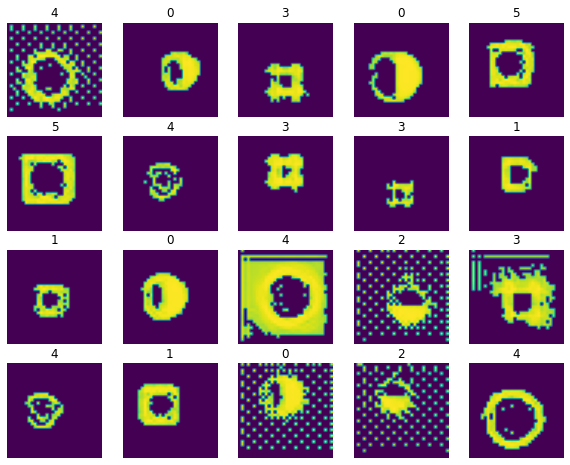

In [ ]:
# Визуализируем результаты интерпретации
# На учебном наборе - не случилось ли переобучения
msks = data_interpretate[2]
mrks = data_interpretate[3]

idx_rnd = np.random.randint(0, len(mrks), 20)
print(idx_rnd)

msksList = msks[idx_rnd]
mrksList = mrks[idx_rnd]

pred = mdl3.predict(msksList)
pred = [np.argmax(x) for x in pred]
mdl_wrk.showImgs(msksList*255, pred)

## Сохранение/Загрузка

In [ ]:
# mdl3.save('models/F2_Full_0')

# Задача 5. Сборка и проверка готового решения

## Экземпляры моделей

In [6]:
mdl1_1 = load_model('models/F1_Full_0')
mdl2_1 = load_model('models/F3_Full_30_1')
mdl3_1 = load_model('models/F2_Full_0')

## Готовый класс 

In [7]:
class IPPW_Finder(object):
    def __init__ (self, mdl1, mdl2, mdl3):
        self.mdl1 = mdl1
        self.mdl2 = mdl2
        self.mdl3 = mdl3

    def loadModels (self, mdl1_name, mdl2_name, mdl3_name):
        self.mdl1 = load_model(mdl1_name)
        self.mdl2 = load_model(mdl2_name)
        self.mdl3 = load_model(mdl3_name)

    def findINPPW(self, img, size, step, getRaw=True):
        imgs, crds = dbc.get_ImageSlice(img, size, step, addCoords=True)
        assert np.max(imgs)>1., "Изображения имеют размерность значений меньше 1!"

        # При помощи модели фазы 1 получаем список картинок на которых имеются
        imgs_inppw_predict = self.mdl1.predict(imgs/255)
        ## Отбираем только те изображения на которых имеются ИНППВ
        imgs_with_inppw = []    # ИНДЕКСЫ изображений из исходного набора с наличием ИНППВ
        for i in range(len(imgs_inppw_predict)):
            if np.argmax(imgs_inppw_predict[i])==1:
                imgs_with_inppw.append(i)

        # При помощи модели фазы 2 получаем сегменты
        imgs_with_inppw_segm = self.mdl2.predict(imgs[imgs_with_inppw]/255)
        assert np.max(imgs_with_inppw_segm)<=1., "Изображения имеют размерность значений выше 1!"
        # # Сегментированные изображения передаем функциям поиска координат ИНППВ

        # Обрабатываем предсказание, с тем, чтобы отфильтровать лишние пиксели для последующей подачи модели интерпретации типа ИНППВ
        imgs_with_inppw_segm_f = imgs_with_inppw_segm*255
        imgs_with_inppw_segm_f = np.vectorize(dbc.pntFilter, otypes=[float])(imgs_with_inppw_segm_f)/255

        # Полученные сегментированные изображения отдаем модели 3 фазы для интерпретации
        imgs_inppwType_predict = self.mdl3.predict(imgs_with_inppw_segm_f)


        # Сегментированные изображения передаем функциям поиска координат ИНППВ
        cntr_crds = self.getINPPWCenters(imgs_with_inppw_segm)


        # Сопоставляем изображения с распознанными ИНППВ с их координатами и типом ИНППВ
        inppws = []
        for i in range(len(cntr_crds)):
            img_idx = imgs_with_inppw[i]     # Индекс изображения                                            
            # Формат записи: координата X ИНППВ, координата Y ИНППВ, тип ИНППВ
            data = [crds[img_idx][0] + cntr_crds[i][0], crds[img_idx][1] + cntr_crds[i][1], np.argmax(imgs_inppwType_predict[i])] 

            inppws.append(data)

        if getRaw:
            return inppws
        else:
            return self.getReadyINPPWList(inppws, step*2)
            

    def getImageSliceFromCenter(img, crd, size):
        x0 = crd[0]-int(size/2)
        y0 = crd[1]-int(size/2)
        x1 = x0+size
        y1 = y0+size

        return img[x0:x1,y0:y1,:]

    # Функции поиска центра координат изображений ИНППВ
    def clearImg(self, img, rng=1, c=255, border=0.6):
        maxVal = ((rng*2+1)**2)*c
        # print(maxVal)
        w = img.shape[0]
        h = img.shape[1]

        img_tmp = np.zeros((w,h))

        if np.max(img) < 1.:
            img = img*c
        if img.ndim==3:
            if img.shape[2]==1:
                img.reshape(w, h)
            if img.shape[2]==3:
                img = np.maximum.reduce(img, axis=2) 


        for x in range(w):
            for y in range (h):
                img_tmp[x,y] = self.getNeigbWeight([x,y], img, 1)
                if img_tmp[x,y] <= maxVal*border:
                    img_tmp[x,y] = 0

        return img_tmp

    def getNeigbWeight(self, crd, img, dist):
        tmp = 0
        for x in range(crd[0]-dist, crd[0]+dist+1):
            for y in range(crd[1]-dist, crd[1]+dist+1):
                # print([x,y], img)
                tmp+=self.getPntWeight([x,y], img)
        return tmp

    def getPntWeight(self, crd, img):
        try:
            return img[crd[0]][crd[1]]
        except:
            return 0

    def getINPPWCenter(self, img):
        img_t = self.clearImg(img, border=0.4)

        img_t_ax0 = np.maximum.reduce(img_t, axis=0)        #X
        img_t_ax1 = np.maximum.reduce(img_t, axis=1)        #Y    

        x0, x1, y0, y1 = 0, 0, 0, 0
        for i in range(len(img_t_ax0)):
            x = img_t_ax0[i]
            if x>0 and x0==0:
                x0 = i
            if x>0:
                x1 = i
        for i in range(len(img_t_ax1)):
            y = img_t_ax1[i]
            if y>0 and y0==0:
                y0 = i
            if y>0:
                y1 = i

        return int((x0+x1)/2), int((y0+y1)/2)

    def getINPPWCenters(self, imgs):
        cntr_crds = []
        for img in imgs:
            x, y = self.getINPPWCenter(img)
            cntr_crds. append((x,y))

        return cntr_crds

    def getDist(self, x0,y0,x1,y1):
        return pow(abs(x1-x0)**2 + abs(y1-y0)**2, 0.5)

    def getPoints(self, arr, pnt):
        arr.append(pnt)
        self.inppw_data_tmp.remove(pnt)
        for inppw in self.inppw_data_tmp:
            if self.getDist(pnt[0],pnt[1], inppw[0],inppw[1])<self.min_distance:
                self.getPoints(arr, inppw)

    def getINPPW_Single(self, inppws):
        inppws = np.array(inppws)
        x = np.mean(inppws[:,0])
        y = np.mean(inppws[:,1])
        types = np.bincount(inppws[:,2])
        return int(x), int(y), np.argmax(types)


    def getReadyINPPWList(self, inppw_data, minDist):
        self.inppw_data_tmp = inppw_data.copy()
        self.min_distance =  minDist  # step*2 # Практика показала, что прямая зависимость от шага нарезки, дает плахие результаты

        # Объединим точки с близкими координатами в списки
        inppws_arr = []
        while len(self.inppw_data_tmp)>0:
        # for pnt in inppw_data_tmp:
            pnt = self.inppw_data_tmp[0]
            na=[]
            na.append(pnt)
            self.inppw_data_tmp.remove(pnt)
            for inppw in self.inppw_data_tmp:
                if self.getDist(pnt[0],pnt[1], inppw[0],inppw[1])<self.min_distance:
                    self.getPoints(na, inppw)
            
            inppws_arr.append(na)


        # print(len(inppws_arr))
        # Найдем корреткные значения для каждого из списков
        inppw_readys = []
        for inppws in inppws_arr:
            inppw_ready = self.getINPPW_Single(inppws)
            inppw_readys.append(inppw_ready)

        return inppw_readys            


    def getGeo(self, inppws_correct, img_sizes, coords):
        '''
            Функция возвращает данные о ИНППВ соотнесенные с географическими координатами
            In:
                inppws_correct - полностью распознанные сведения о ИНППВ
                img_sizes - высота и ширина изображения в пикселях
                coords - географические координаты нижнего левого края картинки и верхнего правого
            Out:

        '''
        # нижний левый  угол (геокоординаты)
        xg_0 = coords[1]
        yg_0 = coords[0]
        # верхний правый угол (геокоординаты)
        xg_1 = coords[3]
        yg_1 = coords[2]

        # Ширина в пикселях
        w = img_sizes[1]
        # Высота в пикселях
        h = img_sizes[0]

        # Ширина в градусах (геокоординаты)
        wg = xg_1-xg_0
        # Высота в градусах (геокоординаты)
        hg = yg_1-yg_0


        inppw_geo = []
        for inppw in inppw_readys:
            x = inppw[0]
            y = inppw[1]

            # Пропорция по X (пиксельная)
            xp = x / w
            # Пропорция по Y (пиксельная)
            yp = y / h


            # Координата x (геокоординаты)
            xg = xp * wg
            # Координата y (геокоординаты)
            yg = yp * hg

            # Координата X на карте (геокоординаты)
            xg_m = xg_0 + xg
            # Координата Y на карте (геокоординаты)
            yg_m = yg_1 - yg


            inppw_geo.append((yg_m, xg_m, inppw[2]))
            
        return np.array(inppw_geo)

## Визуализация результатов

In [21]:
# Тест
fndr = IPPW_Finder(mdl1_1, mdl2_1, mdl3_1)

# img_test = Image.open("test_imgs/1_gisp_PN.jpg")
img_test = Image.open("imgs/1_gisp_FN.jpg")

# Получим сырые данные (полный перечень распознанных точек)
inppw_data = fndr.findINPPW(img_test, img_size, step)

# Получаем итоговые, обработанные результаты распознания
inppw_readys = fndr.getReadyINPPWList(inppw_data, 12)
print("Распознано " + str(len(inppw_readys)) + " водоисточников")


22
Распознано 22 водоисточников


In [22]:
# Выведем полный перечень (данные для каждой записи: y, x, типИНППВ)
print(inppw_readys)

[(49, 414, 0), (64, 377, 4), (118, 396, 0), (128, 261, 1), (150, 410, 2), (193, 572, 5), (272, 352, 2), (281, 443, 0), (291, 86, 0), (329, 163, 5), (338, 508, 3), (366, 272, 0), (398, 448, 3), (455, 164, 0), (452, 315, 0), (479, 386, 0), (502, 549, 2), (544, 469, 4), (555, 298, 2), (566, 559, 4), (570, 260, 0), (574, 369, 1)]


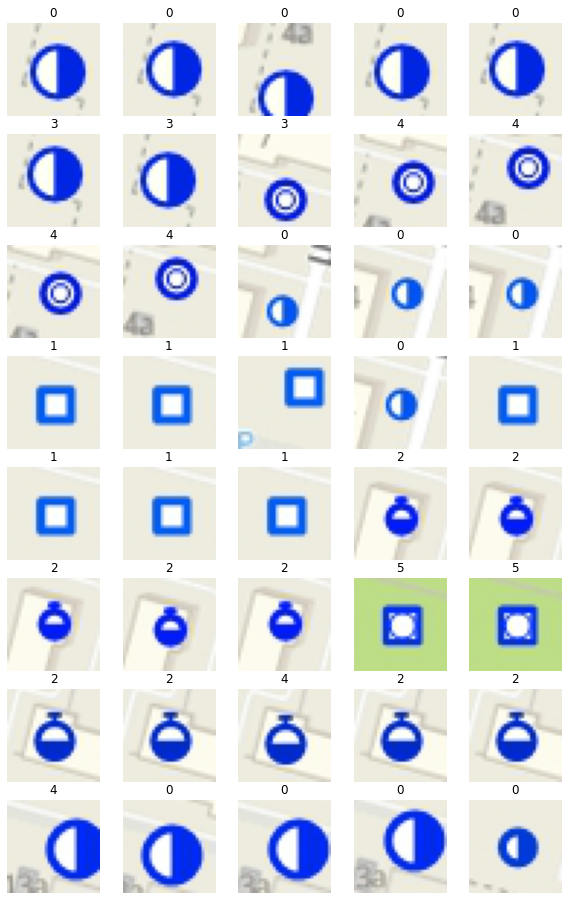

In [23]:
# Показ примера распознанных ИНППВ
img_crops = []
inppw_types = []
inppw_crds = []

for img_i in range(len(inppw_data)):
    crds_for_crop = [
        inppw_data[img_i][0]-16,
        inppw_data[img_i][1]-16,
        inppw_data[img_i][0]+16,
        inppw_data[img_i][1]+16
    ]
    inppw_types.append(inppw_data[img_i][2])
    img_crops.append(dbc.get_ImageSlice_Single(img_test, crds_for_crop))

    inppw_crds.append((inppw_data[img_i][0], inppw_data[img_i][1]))

mdl_wrk.showImgs(img_crops[:40], inppw_types[:40])

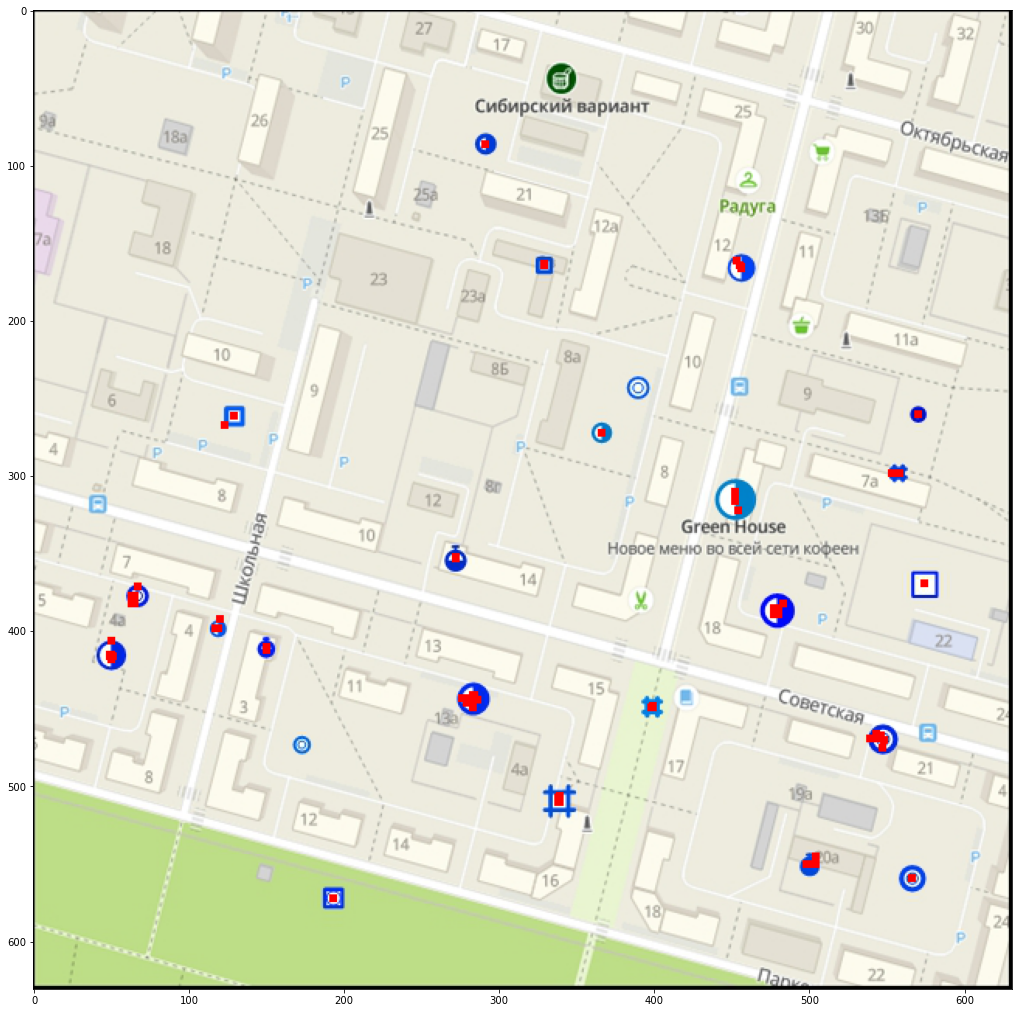

In [24]:
# Визуализация черновых результатов на карте
img_test_copy = np.array(img_test.copy())
for img_data in inppw_crds:
    for x in range(-2, 3):
        for y in range(-2, 3):
            img_test_copy[img_data[1]+x,img_data[0]+y,:] = [255,0,0]   

plt.figure(figsize=(18,18))
plt.imshow(img_test_copy)

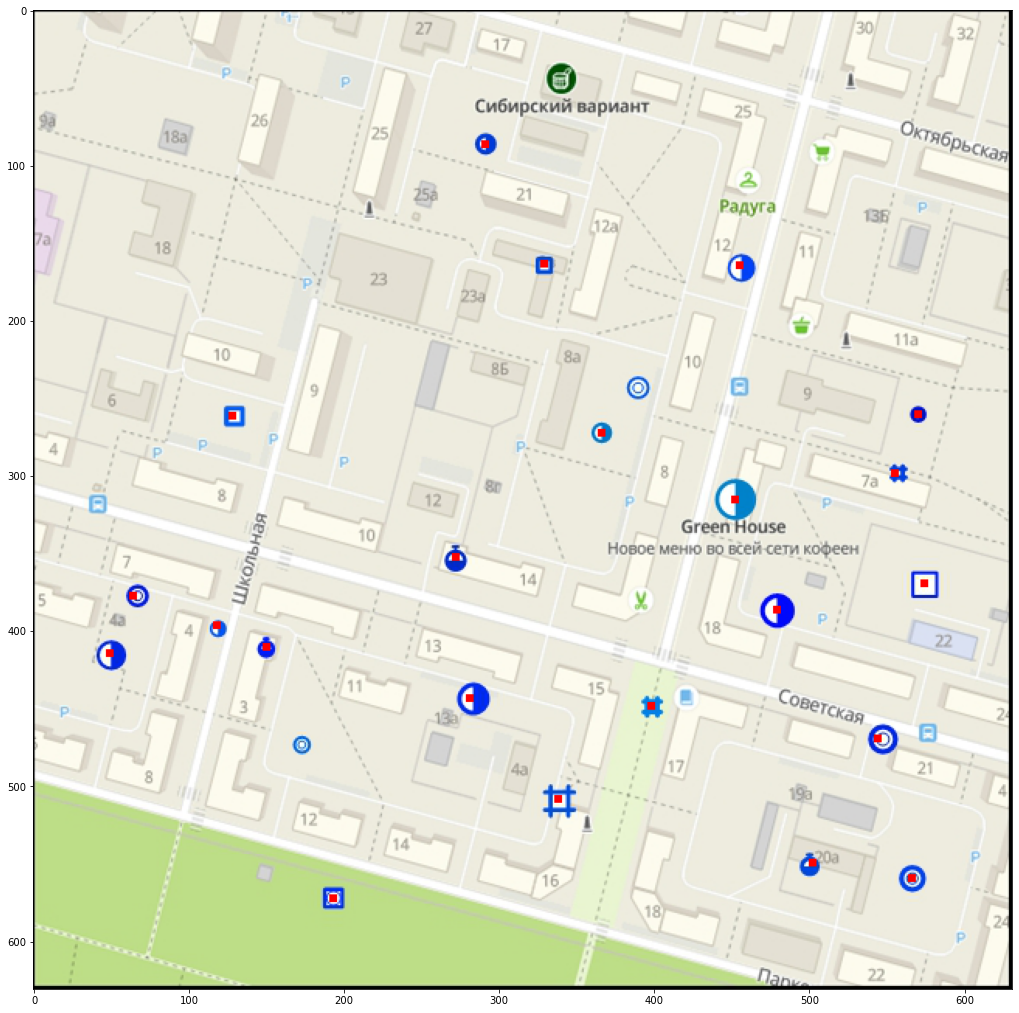

In [50]:
# Визуализация Обработанных результатов
# Создаем копию исходного изображения
img_test_copy = np.array(img_test.copy())

# Переберем полученные координаты
for inppw_ready in inppw_readys:
    # Покажем полученные значения на иходной карте
    for x in range(-2, 3):
        for y in range(-2, 3):
            img_test_copy[inppw_ready[1]+x,inppw_ready[0]+y,:] = [255,0,0]   

plt.figure(figsize=(18,18))
plt.imshow(img_test_copy)


## Покажем полученные результаты на карте

In [47]:
# Тест
fndr = IPPW_Finder(mdl1_1, mdl2_1, mdl3_1)

img_test = Image.open("imgs/1_gisp_FN.jpg")

# Получаем сразу итоговые, обработанные результаты распознания
inppw_readys = fndr.findINPPW(img_test, img_size, 6, False)

print("Распознано " + str(len(inppw_readys)) + " водоисточников")

Распознано 22 водоисточников


In [48]:
coords = [56.244357, 93.523568, 56.248864, 93.531847]
geo_inppw = fndr.getGeo(inppw_readys, np.array(img_test).shape[:2], coords)
print(geo_inppw.shape)
print(geo_inppw[:10])

(22, 3)
[[56.24590695 93.5242109   0.        ]
 [56.24617123 93.52440771  4.        ]
 [56.24603552 93.52511621  0.        ]
 [56.24699977 93.52524742  1.        ]
 [56.24593552 93.52553607  2.        ]
 [56.24477842 93.52610025  5.        ]
 [56.24634979 93.52713676  2.        ]
 [56.24569981 93.52725484  0.        ]
 [56.24824973 93.52738605  0.        ]
 [56.24769975 93.52788463  5.        ]]


In [49]:
colors = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'orange',
    4: 'darkgreen',
    5: 'purple'
}

m = folium.Map(location=[(coords[2]+coords[0])/2, (coords[3]+coords[1])/2], zoom_start=16)
for i in range(geo_inppw.shape[0]):
    inppw = geo_inppw[i]

    folium.Marker(
        [inppw[0], inppw[1]],
        icon=folium.Icon(color=colors[inppw[2]], icon="info-sign"),
        ).add_to(m)


m

# Итоговые примеры использования

In [8]:
# Загрузим модели:
mdl1_1 = load_model('models/F1_Full_0')
mdl2_1 = load_model('models/F3_Full_30_1')
mdl3_1 = load_model('models/F2_Full_0')
# Создадим экземпляр интерпретатора:
fndr = IPPW_Finder(mdl1_1, mdl2_1, mdl3_1)

## Пример показа отметок с распознанными ИНППВ на изображении

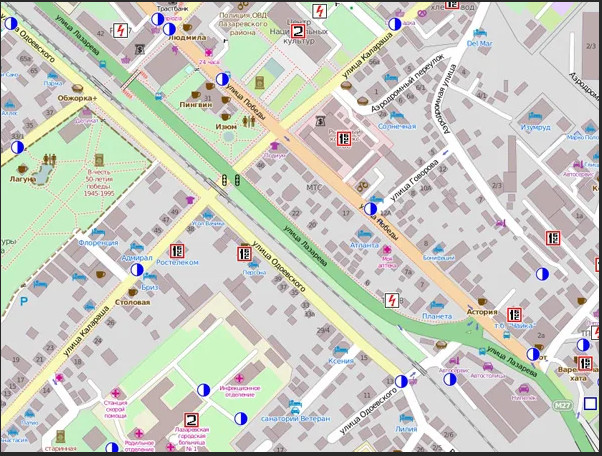

In [51]:
img_test = Image.open("test_imgs/broken.jpg")
img_test

In [54]:
# Получаем сразу итоговые, обработанные результаты распознания
inppw_readys = fndr.findINPPW(img_test, img_size, 4, False)
print(len(inppw_readys))
if len(inppw_readys)<10:
    print(inppw_readys)
else:
    print(inppw_readys[:10]) 

10
[(18, 149, 0), (140, 271, 3), (164, 24, 0), (203, 393, 0), (242, 422, 0), (396, 27, 0), (403, 382, 0), (452, 381, 0), (544, 275, 0), (584, 348, 0)]


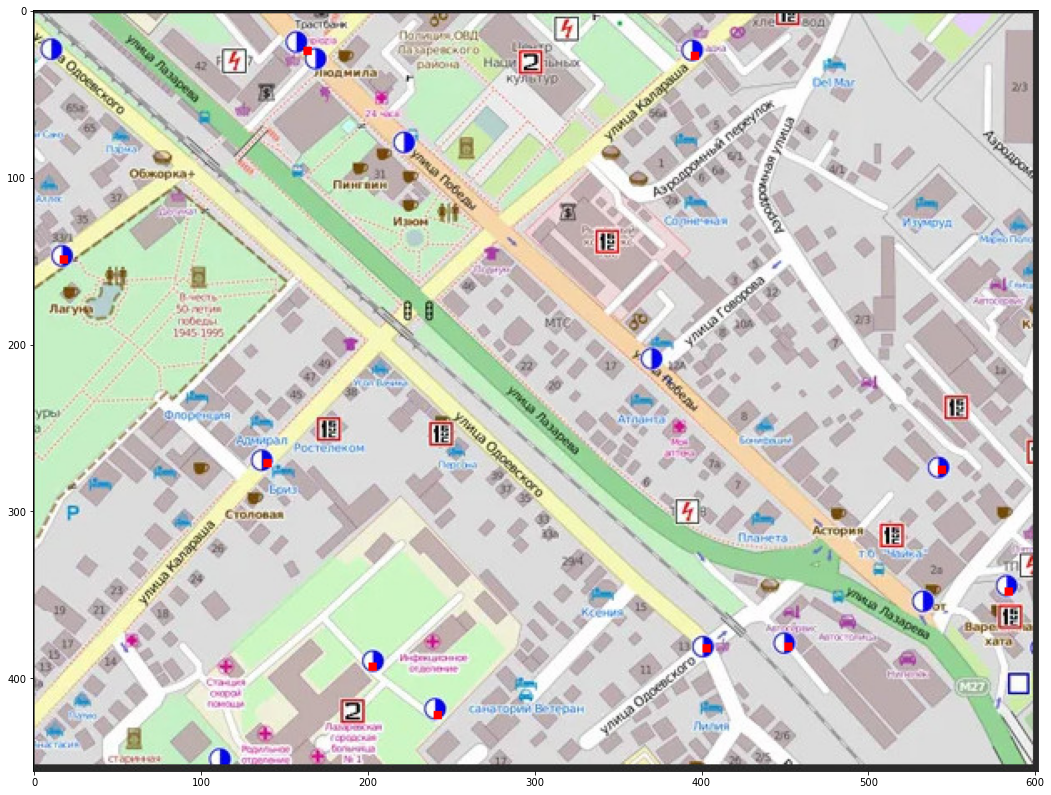

In [55]:
# Визуализация результатов на карте
img_test_copy = np.array(img_test.copy())
for img_data in inppw_readys:
    for x in range(-2, 3):
        for y in range(-2, 3):
            try:
                img_test_copy[img_data[1]+x,img_data[0]+y,:] = [255,0,0]   
            except:
                pass

plt.figure(figsize=(18,18))
plt.imshow(img_test_copy)

## Пример показа отметок с распознанными ИНППВ на карте folium

### 1

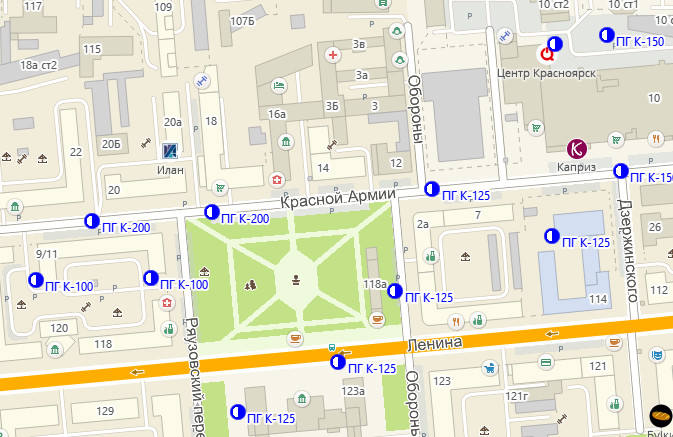

In [56]:
coords = [56.011962, 92.848499, 56.014873, 92.856813]

img_test = Image.open("test_imgs/2GIS_EWS.jpg")
img_test

In [57]:
# Получаем сразу итоговые, обработанные результаты распознания
inppw_readys = fndr.findINPPW(img_test, img_size, 4, False)

geo_inppw = fndr.getGeo(inppw_readys, np.array(img_test).shape[:2], coords)

print(geo_inppw.shape)

(13, 3)


In [73]:
for inppw in geo_inppw:
    print(inppw[0], inppw[1], "\t", imppw_types_dict[inppw[2]])

56.015005849999994 92.84840370464134 	 ПГ
56.013016549999996 92.84912307172995 	 ПГ
56.013389543749994 92.84980647046413 	 ПГ
56.013016549999996 92.85050185864979 	 ПГ
56.01345498125 92.8512212257384 	 ПГ
56.01248650625 92.85275587552742 	 ПГ
56.0129511125 92.85340330590716 	 ПГ
56.015247968749996 92.85361911603376 	 ПГ
56.01361203125 92.85387089451477 	 ПГ
56.01528723125 92.85497392405063 	 ПГ
56.014541243749996 92.85528564978902 	 ПГ
56.013304475 92.85530962869198 	 ПГ
56.014613225 92.8559690485232 	 ПГ
56.01371673125 92.8561249113924 	 ПГ
56.01388686875 92.85717998312235 	 ПГ
56.013926131249995 92.85789935021097 	 ПГ
56.01379525625 92.85837892827004 	 ПГ
56.012833324999995 92.85852280168776 	 ПГ
56.014083181249994 92.85857075949366 	 ПГ


In [61]:
colors = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'orange',
    4: 'darkgreen',
    5: 'purple'
}

m = folium.Map(location=[(coords[2]+coords[0])/2, (coords[3]+coords[1])/2], zoom_start=16)
for i in range(geo_inppw.shape[0]):
    inppw = geo_inppw[i]

    folium.Marker(
        [inppw[0], inppw[1]],
        icon=folium.Icon(color=colors[inppw[2]], icon="info-sign"),
        tooltip=imppw_types_dict[inppw[2]],

        ).add_to(m)


m

Все ИНППВ распознаны корректно!!! 

Только появился еще один ИНППВ - "Башня". Скореевсего это связано с тем, что на исходном изображении в данном месте имеются буквы схожие с очертаниями метки "Башня" - Большая буква "О".

### 2

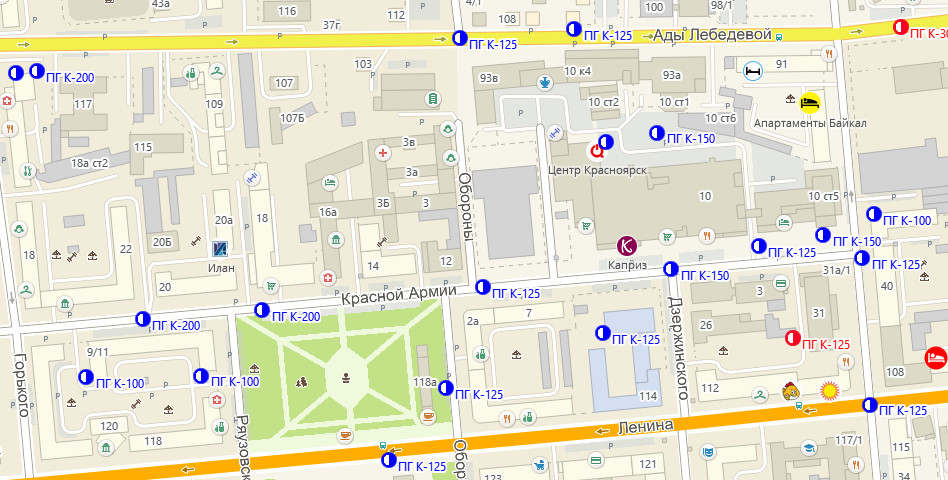

In [62]:
coords = [56.012336, 92.848068, 56.015477, 92.859434]

img_test = Image.open("test_imgs/2GIS_EWS_2.jpg")
img_test

In [63]:
inppw_readys = fndr.findINPPW(img_test, img_size, 6, False)
geo_inppw = fndr.getGeo(inppw_readys, np.array(img_test).shape[:2], coords)

print(geo_inppw.shape)

(19, 3)


In [64]:
for inppw in geo_inppw:
    print(inppw[:2], imppw_types_dict[inppw[2]])

[56.01500585 92.8484037 ] ПГ
[56.01301655 92.84912307] ПГ
[56.01338954 92.84980647] ПГ
[56.01301655 92.85050186] ПГ
[56.01345498 92.85122123] ПГ
[56.01248651 92.85275588] ПГ
[56.01295111 92.85340331] ПГ
[56.01524797 92.85361912] ПГ
[56.01361203 92.85387089] ПГ
[56.01528723 92.85497392] ПГ
[56.01454124 92.85528565] ПГ
[56.01330447 92.85530963] ПГ
[56.01461322 92.85596905] ПГ
[56.01371673 92.85612491] ПГ
[56.01388687 92.85717998] ПГ
[56.01392613 92.85789935] ПГ
[56.01379526 92.85837893] ПГ
[56.01283332 92.8585228 ] ПГ
[56.01408318 92.85857076] ПГ


In [65]:
m = folium.Map(location=[(coords[2]+coords[0])/2, (coords[3]+coords[1])/2], zoom_start=16)
for i in range(geo_inppw.shape[0]):
    inppw = geo_inppw[i]

    folium.Marker(
        [inppw[0], inppw[1]],
        icon=folium.Icon(color=colors[inppw[2]], icon="info-sign"),
        tooltip=imppw_types_dict[inppw[2]],
        ).add_to(m)


m

Распознаны все отметки ИНППВ! Исключение - два ПГ в верхнем левом углу расположенные близко друг к другу - они слились в один, но это проблема не нейронной сети, а алгоритма объединения точек с разных картинок нарезки.

### Сохранение в файл Excel

In [74]:
import pandas as pd

In [80]:
df = pd.DataFrame(geo_inppw, columns=['lat', 'lon', 'Тип']).to_excel("ИНППВ.xls")


C:\Users\obsid\AppData\Local\Temp/ipykernel_5392/52041010.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df = pd.DataFrame(geo_inppw, columns=['lat', 'lon', 'Тип']).to_excel("ИНППВ.xls")


# Заключение

Полученное решение может быть использовано при оцифровке бумажных вариантов планшетов водоисточников имеющихся в пожарных подразделениях. Точность полученных результатов высока - распознаются почти все ИНППВ. Однако следует иметь в виду, что в реальности метки ИНППВ могут быть нанесены в том числе при помощи ручки или карандаша, так что при дальнейшей доработке данного решения следует учесть, что НС необходимо обучать так же и на этих изображениях. В идеале - было бы взять реальные изображения ИНППВ и обучить НС на них. 

Так же на будущее можно рассмотреть возможность объединения всех трех моделей НС в единую модель.